In [6]:
import numpy as np
from scipy.special import digamma  # dla H(n) = digamma(n + 1) - digamma(1)


def generate_network_data(n_normal=950, n_anomaly=50, random_state=42):
    """Generuje dane ruchu sieciowego z anomaliami."""
    np.random.seed(random_state)

    # Normalny ruch - 3 klastry operacyjne
    normal = np.vstack([
        np.random.randn(n_normal // 3, 4) * 0.5 + [50, 100, 0.8, 30],
        np.random.randn(n_normal // 3, 4) * 0.5 + [55, 110, 0.75, 35],
        np.random.randn(n_normal // 3, 4) * 0.5 + [48, 95, 0.85, 28],
    ])

    # Anomalie - rozne wzorce atakow
    anomalies = np.vstack([
        np.random.randn(n_anomaly // 2, 4) * 0.3 + [200, 500, 0.1, 5],   # DDoS
        np.random.randn(n_anomaly // 2, 4) * 0.3 + [10, 10, 0.99, 100],  # Port scan
    ])

    X = np.vstack([normal, anomalies])
    y = np.array([0] * len(normal) + [1] * len(anomalies))
    return X, y


class IsolationTree:
    """Pojedyncze drzewo izolujace."""

    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, current_depth=0):
        """Buduje drzewo z losowymi podzialami (bez etykiet!)."""
        n_samples, n_features = X.shape

        # Warunek stopu
        if n_samples <= 1 or (self.max_depth is not None and current_depth >= self.max_depth):
            return {
                'type': 'leaf',
                'size': n_samples,
                'depth': current_depth,
            }

        # TODO: Losuj ceche i prog
        feature = np.random.randint(0, n_features)
        min_val, max_val = X[:, feature].min(), X[:, feature].max()

        if min_val == max_val:
            return {
                'type': 'leaf',
                'size': n_samples,
                'depth': current_depth,
            }
        
        threshold = np.random.uniform(min_val, max_val)

        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold

        if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
            return {
                'type': 'leaf',
                'size': n_samples,
                'depth': current_depth,
            }
        
        left_subtree = self.fit(X[left_indices], current_depth + 1)
        right_subtree = self.fit(X[right_indices], current_depth + 1)

        return {
            'type': 'node',
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree,
            'depth': current_depth,
        }

    def path_length(self, x, node=None, current_depth=0):
        """Oblicza glebokosc izolacji punktu x."""
        # TODO: Rekurencyjnie przejdz drzewo az do liscia
        if node is None:
            node = self.root
        
        if node['type'] == 'leaf':
            return current_depth
        
        feature = node['feature']
        threshold = node['threshold']

        if x[feature] < threshold:
            return self.path_length(x, node['left'], current_depth + 1)
        else:
            return self.path_length(x, node['right'], current_depth + 1)


def c_factor(n):
    """Oblicza oczekiwana glebokosc BST dla n elementow."""
    if n <= 1:
        return 0
    return 2 * (np.log(n - 1) + 0.5772156649) - 2 * (n - 1) / n


def anomaly_score(path_lengths, n_samples):
    """Oblicza znormalizowany anomaly score."""
    c = c_factor(n_samples)
    return 2 ** (-np.array(path_lengths) / c)


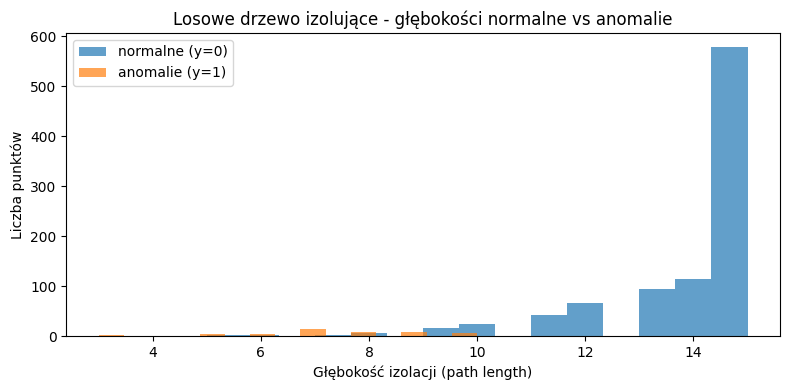

In [7]:
import matplotlib.pyplot as plt

def part_a_random_isolation_tree_hist():
    X, y = generate_network_data()

    tree = IsolationTree(max_depth=15)
    tree.root = tree.fit(X)

    path_lengths = []
    for i in range(len(X)):
        x = X[i]
        h = tree.path_length(x)
        path_lengths.append(h)

    path_lengths = np.array(path_lengths)

    normal_lengths = path_lengths[y == 0]
    anomaly_lengths = path_lengths[y == 1]

    plt.figure(figsize=(8, 4))
    plt.hist(normal_lengths, bins=15, alpha=0.7, label="normalne (y=0)")
    plt.hist(anomaly_lengths, bins=15, alpha=0.7, label="anomalie (y=1)")
    plt.xlabel("Głębokość izolacji (path length)")
    plt.ylabel("Liczba punktów")
    plt.title("Losowe drzewo izolujące - głębokości normalne vs anomalie")
    plt.legend()
    plt.tight_layout()
    plt.show()

part_a_random_isolation_tree_hist()

Średnia głębokość normalnych: 9.82
Średnia głębokość anomalii  : 2.8333333333333335
Przykładowe głębokości anomalii: [2 3 3 3 3 3]


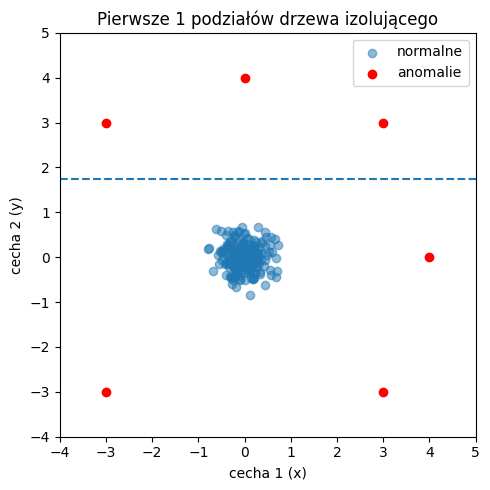

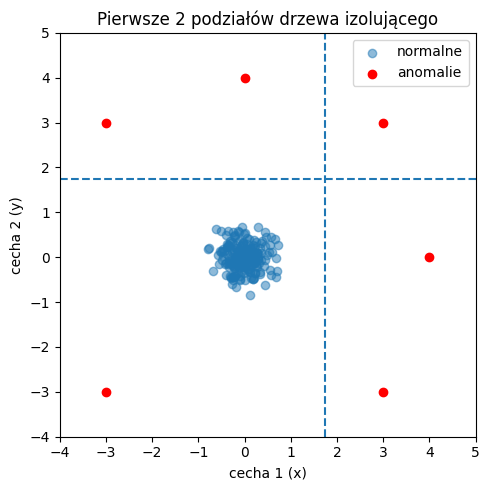

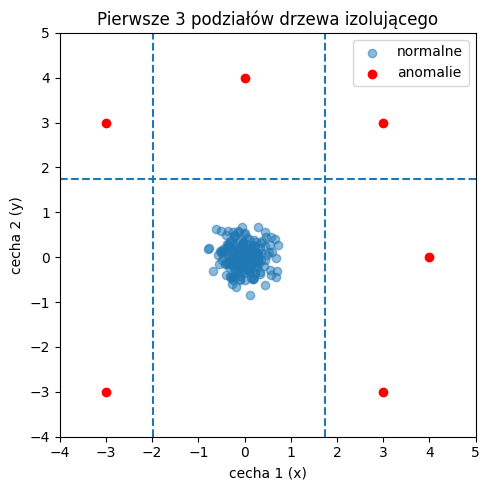

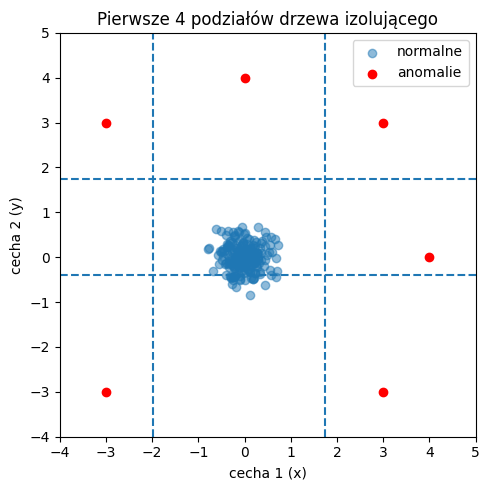

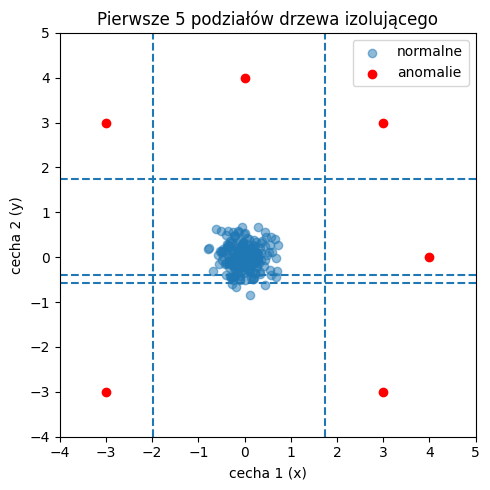

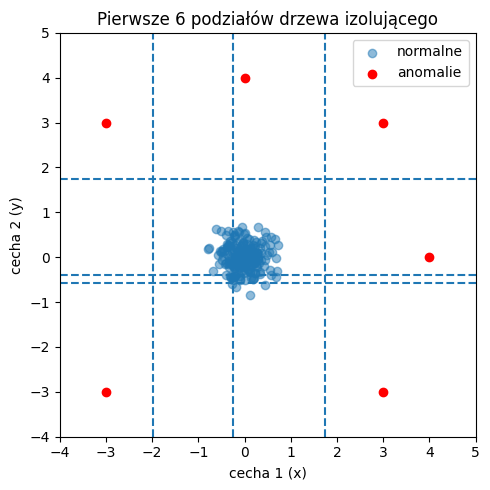

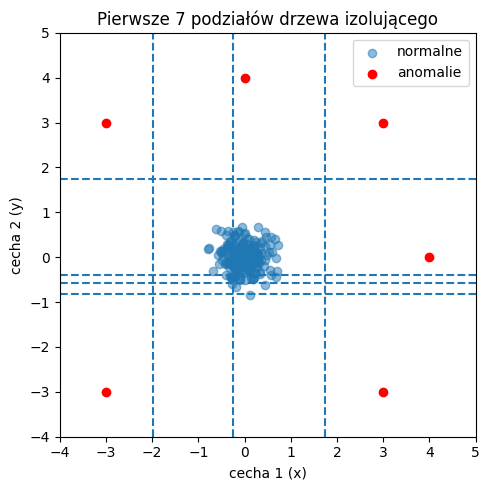

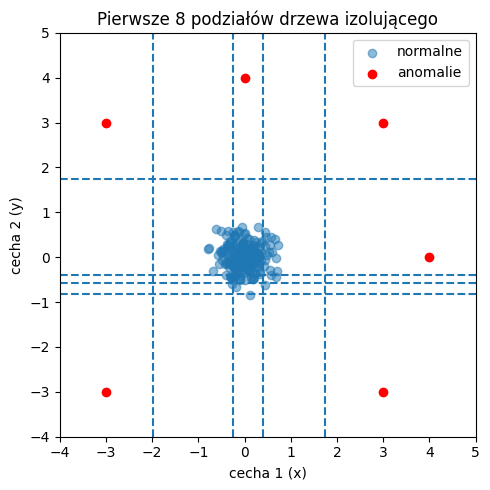

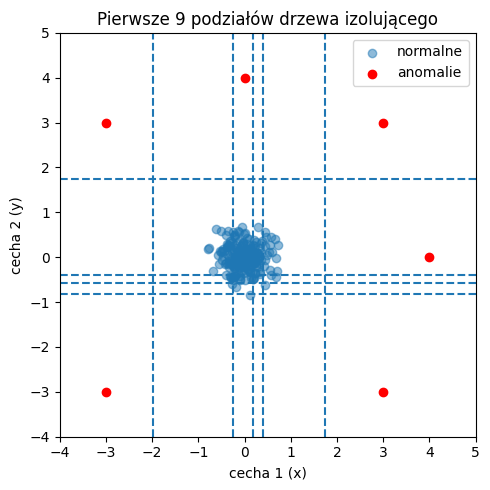

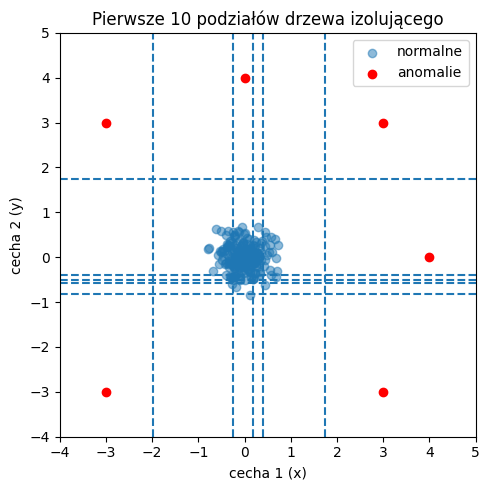

In [8]:
def generate_2d_data(n_normal=200, random_state=0):
    np.random.seed(random_state)

    normal = np.random.randn(n_normal, 2) * 0.3 + [0.0, 0.0]

    anomalies = np.array([
        [3.0, 3.0],
        [3.0, -3.0],
        [-3.0, 3.0],
        [-3.0, -3.0],
        [4.0, 0.0],
        [0.0, 4.0],
    ])

    X = np.vstack([normal, anomalies])
    y = np.array([0] * len(normal) + [1] * len(anomalies))
    return X, y


def collect_splits(node, splits, max_splits=None):
    if node['type'] == 'leaf':
        return

    splits.append((node['feature'], node['threshold']))

    if max_splits is not None and len(splits) >= max_splits:
        return

    collect_splits(node['left'], splits, max_splits)
    collect_splits(node['right'], splits, max_splits)


def geometry_2d():
    X, y = generate_2d_data()

    tree = IsolationTree(max_depth=10)
    tree.root = tree.fit(X)

    splits = []
    collect_splits(tree.root, splits)

    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    depths = np.array([tree.path_length(x) for x in X])
    normal_depths = depths[y == 0]
    anomaly_depths = depths[y == 1]

    print("Średnia głębokość normalnych:", normal_depths.mean())
    print("Średnia głębokość anomalii  :", anomaly_depths.mean())
    print("Przykładowe głębokości anomalii:", anomaly_depths)

    max_k = min(10, len(splits))

    for k in range(1, max_k + 1):
        plt.figure(figsize=(5, 5))

        plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5, label="normalne")
        plt.scatter(X[y == 1, 0], X[y == 1, 1], c="red", label="anomalie")

        for feature, threshold in splits[:k]:
            if feature == 0:
                plt.axvline(threshold, linestyle="--")
            else:
                plt.axhline(threshold, linestyle="--")

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel("cecha 1 (x)")
        plt.ylabel("cecha 2 (y)")
        plt.title(f"Pierwsze {k} podziałów drzewa izolującego")
        plt.legend()
        plt.tight_layout()
        plt.show()

geometry_2d()

Średni anomaly score (normalne): 0.5219858135560161
Średni anomaly score (anomalia): 0.7299013503201113


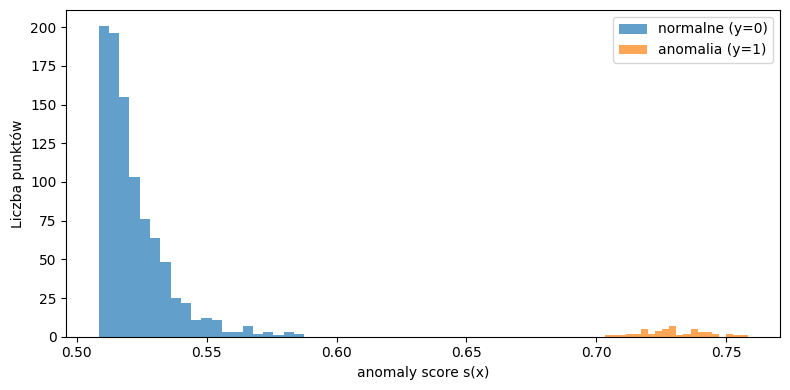

In [9]:
def build_forest(X, n_trees=100, max_samples=256, max_depth=10, random_state=42):
    rng = np.random.RandomState(random_state)
    n_samples = len(X)
    sample_size = min(max_samples, n_samples)

    trees = []

    for i in range(n_trees):
        indices = rng.choice(n_samples, size=sample_size, replace=False)
        X_sub = X[indices]

        tree = IsolationTree(max_depth=max_depth)
        tree.root = tree.fit(X_sub) 
        trees.append(tree)

    return trees, sample_size

def ensemble_anomaly_scores(X, trees, sample_size):
    n_samples = len(X)
    n_trees = len(trees)

    all_lengths = np.zeros((n_samples, n_trees))

    for j, tree in enumerate(trees):
        all_lengths[:, j] = [tree.path_length(x) for x in X]

    mean_lengths = all_lengths.mean(axis=1)

    scores = anomaly_score(mean_lengths, sample_size)
    return scores


def part_c():
    X, y = generate_network_data()

    trees, sample_size = build_forest(
        X,
        n_trees=100,
        max_samples=256,
        max_depth=10,
        random_state=42,
    )

    scores = ensemble_anomaly_scores(X, trees, sample_size)

    normal_scores = scores[y == 0]
    anomaly_scores_vals = scores[y == 1]

    print("Średni anomaly score (normalne):", normal_scores.mean())
    print("Średni anomaly score (anomalia):", anomaly_scores_vals.mean())

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    plt.hist(normal_scores, bins=20, alpha=0.7, label="normalne (y=0)")
    plt.hist(anomaly_scores_vals, bins=20, alpha=0.7, label="anomalia (y=1)")
    plt.xlabel("anomaly score s(x)")
    plt.ylabel("Liczba punktów")
    plt.legend()
    plt.tight_layout()
    plt.show()

part_c()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def evaluate_scores(y_true, scores, n_thresholds=100):
    scores = np.asarray(scores)
    thr_min, thr_max = scores.min(), scores.max()
    thresholds = np.linspace(thr_min, thr_max, n_thresholds)

    best_f1 = -1
    best_p = best_r = best_thr = None

    for thr in thresholds:
        y_pred = (scores >= thr).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_p = p
            best_r = r
            best_thr = thr

    return best_p, best_r, best_f1, best_thr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

def print_eval(name, y_true, scores):
    p, r, f1, thr = evaluate_scores(y_true, scores)
    print(f"\n{name}")
    print(f"precision = {p:.3f}, recall = {r:.3f}, F1 = {f1:.3f}, threshold = {thr:.4f}")
    return p, r, f1, thr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

def evaluate_custom_vs_sklearn():
    X, y = generate_network_data()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    trees, sample_size = build_forest(
        X_train,
        n_trees=100,
        max_samples=256,
        max_depth=10,
        random_state=42,
    )
    scores_custom = ensemble_anomaly_scores(X_test, trees, sample_size)
    print_eval("Custom Isolation Forest", y_test, scores_custom)

    sk_if = IsolationForest(
        n_estimators=100,
        max_samples=256,
        contamination=0.05,
        random_state=42,
    )
    sk_if.fit(X_train)
    scores_sk = -sk_if.score_samples(X_test)
    print_eval("sklearn IsolationForest", y_test, scores_sk)

    corr = np.corrcoef(scores_custom, scores_sk)[0, 1]
    print(f"\nKorelacja score'ów custom vs sklearn: {corr:.3f}")

    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.05,
        novelty=True,
    )
    lof.fit(X_train)
    scores_lof = -lof.score_samples(X_test)
    print_eval("Local Outlier Factor (LOF)", y_test, scores_lof)

    ocsvm = OneClassSVM(
        kernel="rbf",
        gamma="scale",
        nu=0.05,
    )
    ocsvm.fit(X_train[y_train == 0])
    scores_oc = -ocsvm.decision_function(X_test)
    print_eval("One-Class SVM", y_test, scores_oc)

def sweep_forest_params():
    X, y = generate_network_data()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    for n_trees in [50, 100, 200]:
        for max_samples in [64, 128, 256]:
            trees, sample_size = build_forest(
                X_train,
                n_trees=n_trees,
                max_samples=max_samples,
                max_depth=10,
                random_state=42,
            )
            scores = ensemble_anomaly_scores(X_test, trees, sample_size)
            p, r, f1, thr = evaluate_scores(y_test, scores)
            print(f"n_trees={n_trees:3d}, max_samples={max_samples:3d} -> F1={f1:.3f}")

evaluate_custom_vs_sklearn()
print("\n\n>>> Eksperyment z liczbą drzew i max_samples")
sweep_forest_params()




Custom Isolation Forest
precision = 1.000, recall = 1.000, F1 = 1.000, threshold = 0.5724

sklearn IsolationForest
precision = 1.000, recall = 1.000, F1 = 1.000, threshold = 0.5436

Korelacja score'ów custom vs sklearn: 0.968

Local Outlier Factor (LOF)
precision = 1.000, recall = 1.000, F1 = 1.000, threshold = 2.2412

One-Class SVM
precision = 1.000, recall = 1.000, F1 = 1.000, threshold = 0.1167


>>> Eksperyment z liczbą drzew i max_samples
n_trees= 50, max_samples= 64 -> F1=1.000
n_trees= 50, max_samples=128 -> F1=1.000
n_trees= 50, max_samples=256 -> F1=1.000
n_trees=100, max_samples= 64 -> F1=1.000
n_trees=100, max_samples=128 -> F1=1.000
n_trees=100, max_samples=256 -> F1=1.000
n_trees=200, max_samples= 64 -> F1=1.000
n_trees=200, max_samples=128 -> F1=1.000
n_trees=200, max_samples=256 -> F1=1.000
